In [96]:
import pandas as pd
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
import shap

In [97]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [98]:
# Provide the path to the file in your Google Drive
file_path = '/content/drive/My Drive/Colab Notebooks/DBA5102/Advertising_Kaggle/data/Advertising Budget and Sales.csv'

# Read the CSV file
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
print(df.head())

   Unnamed: 0  TV Ad Budget ($)  Radio Ad Budget ($)  Newspaper Ad Budget ($)  \
0           1             230.1                 37.8                     69.2   
1           2              44.5                 39.3                     45.1   
2           3              17.2                 45.9                     69.3   
3           4             151.5                 41.3                     58.5   
4           5             180.8                 10.8                     58.4   

   Sales ($)  
0       22.1  
1       10.4  
2        9.3  
3       18.5  
4       12.9  


<h1>EDA</h1>

In [99]:
# Rename columns for easier access
df.rename(columns={
    'TV Ad Budget ($)': 'TV_Budget',
    'Radio Ad Budget ($)': 'Radio_Budget',
    'Newspaper Ad Budget ($)': 'Newspaper_Budget',
    'Sales ($)': 'Sales'
}, inplace=True)

In [100]:
# Check data types
print(df.dtypes)

# Convert columns to numeric if necessary
df = df.astype({
    'TV_Budget': 'float',
    'Radio_Budget': 'float',
    'Newspaper_Budget': 'float',
    'Sales': 'float'
})

Unnamed: 0            int64
TV_Budget           float64
Radio_Budget        float64
Newspaper_Budget    float64
Sales               float64
dtype: object


In [101]:
df.describe()

,Unnamed: 0,TV_Budget,Radio_Budget,Newspaper_Budget,Sales
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,147.042500,23.264000,30.554000,14.022500
std,57.879185,85.854236,14.846809,21.778621,5.217457
min,1.000000,0.700000,0.000000,0.300000,1.600000
25%,50.750000,74.375000,9.975000,12.750000,10.375000
50%,100.500000,149.750000,22.900000,25.750000,12.900000
75%,150.250000,218.825000,36.525000,45.100000,17.400000
max,200.000000,296.400000,49.600000,114.000000,27.000000


In [102]:
# Check for missing values
print(df.isnull().sum())

Unnamed: 0          0
TV_Budget           0
Radio_Budget        0
Newspaper_Budget    0
Sales               0
dtype: int64


In [103]:
# Check for duplicates
print(df.duplicated().sum())

# Remove duplicates if any
df.drop_duplicates(inplace=True)

0


In [104]:
# Create a new column for total advertising budget
df['Total_Budget'] = df['TV_Budget'] + df['Radio_Budget'] + df['Newspaper_Budget']

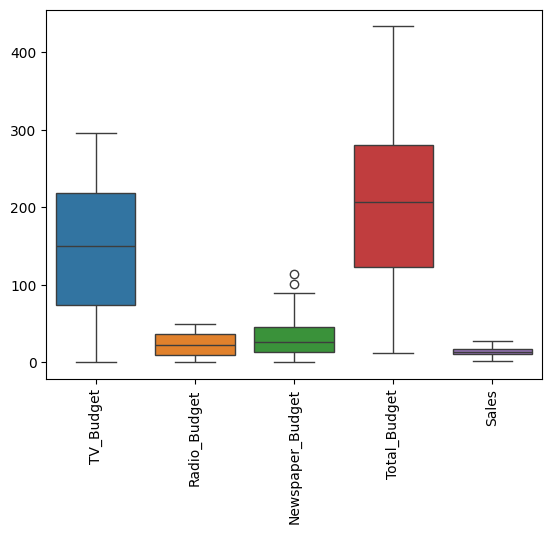

In [105]:
ax = sns.boxplot(data=df[['TV_Budget', 'Radio_Budget', 'Newspaper_Budget', 'Total_Budget', 'Sales']])
ax.tick_params(axis='x', rotation=90)
plt.show()

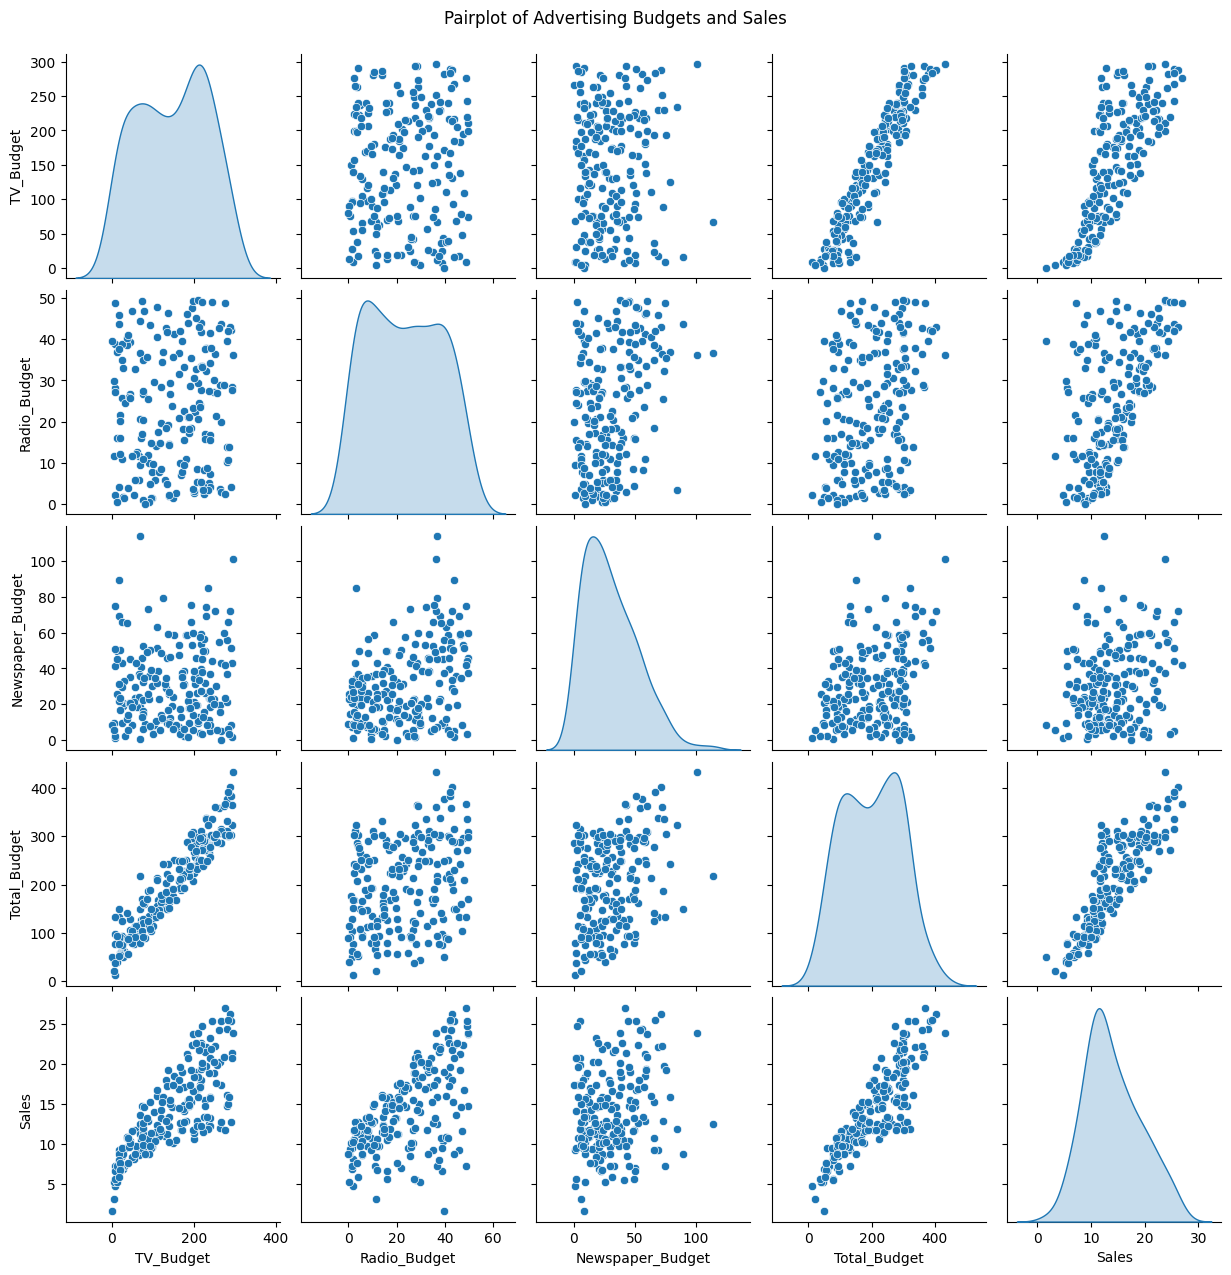

In [106]:
# Visualize distributions of advertising budgets and sales
sns.pairplot(df[['TV_Budget', 'Radio_Budget', 'Newspaper_Budget', 'Total_Budget', 'Sales']], diag_kind='kde')
plt.suptitle("Pairplot of Advertising Budgets and Sales", y=1.02)
plt.show()

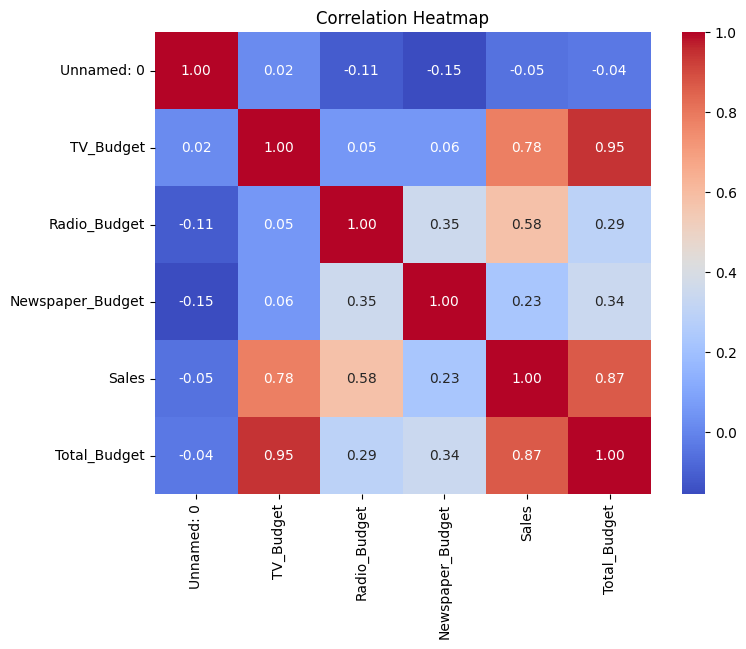

In [107]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

<h1>Adding some features</h1>

In [108]:
# 1. Interaction terms between advertising budgets
df['TV_Radio_Interaction'] = df['TV_Budget'] * df['Radio_Budget']
df['TV_Newspaper_Interaction'] = df['TV_Budget'] * df['Newspaper_Budget']
df['Radio_Newspaper_Interaction'] = df['Radio_Budget'] * df['Newspaper_Budget']

In [109]:
df['TV_Radio_Ratio'] = df['TV_Budget'] / (df['Radio_Budget'] + 1e-5)
df['TV_Newspaper_Ratio'] = df['TV_Budget'] / (df['Newspaper_Budget'] + 1e-5)
df['Radio_Newspaper_Ratio'] = df['Radio_Budget'] / (df['Newspaper_Budget'] + 1e-5)

In [110]:
df['Log_TV'] = np.log1p(df['TV_Budget'])
df['Log_Radio'] = np.log1p(df['Radio_Budget'])
df['Log_Newspaper'] = np.log1p(df['Newspaper_Budget'])

In [111]:
df['TV_Squared'] = df['TV_Budget'] ** 2
df['Radio_Squared'] = df['Radio_Budget'] ** 2
df['Newspaper_Squared'] = df['Newspaper_Budget'] ** 2

df['TV_Sqrt'] = np.sqrt(df['TV_Budget'])
df['Radio_Sqrt'] = np.sqrt(df['Radio_Budget'])
df['Newspaper_Sqrt'] = np.sqrt(df['Newspaper_Budget'])

In [112]:
df['Mean_Ad_Budget'] = df[['TV_Budget', 'Radio_Budget', 'Newspaper_Budget']].mean(axis=1)
df['Std_Ad_Budget'] = df[['TV_Budget', 'Radio_Budget', 'Newspaper_Budget']].std(axis=1)
df['Max_Ad_Budget'] = df[['TV_Budget', 'Radio_Budget', 'Newspaper_Budget']].max(axis=1)
df['Min_Ad_Budget'] = df[['TV_Budget', 'Radio_Budget', 'Newspaper_Budget']].min(axis=1)

In [113]:
df['TV_Normalized'] = (df['TV_Budget'] - df['TV_Budget'].mean()) / df['TV_Budget'].std()
df['Radio_Normalized'] = (df['Radio_Budget'] - df['Radio_Budget'].mean()) / df['Radio_Budget'].std()
df['Newspaper_Normalized'] = (df['Newspaper_Budget'] - df['Newspaper_Budget'].mean()) / df['Newspaper_Budget'].std()

In [114]:
df['Cumulative_TV'] = df['TV_Budget'].cumsum()
df['Cumulative_Radio'] = df['Radio_Budget'].cumsum()
df['Cumulative_Newspaper'] = df['Newspaper_Budget'].cumsum()

In [115]:
df['Rolling_Mean_TV'] = df['TV_Budget'].rolling(window=3, min_periods=1).mean()
df['Rolling_Mean_Radio'] = df['Radio_Budget'].rolling(window=3, min_periods=1).mean()
df['Rolling_Mean_Newspaper'] = df['Newspaper_Budget'].rolling(window=3, min_periods=1).mean()

In [116]:
df['EMA_TV'] = df['TV_Budget'].ewm(span=5, adjust=False).mean()
df['EMA_Radio'] = df['Radio_Budget'].ewm(span=5, adjust=False).mean()
df['EMA_Newspaper'] = df['Newspaper_Budget'].ewm(span=5, adjust=False).mean()

In [117]:
df['High_TV_Budget'] = (df['TV_Budget'] > df['TV_Budget'].mean()).astype(int)
df['High_Radio_Budget'] = (df['Radio_Budget'] > df['Radio_Budget'].mean()).astype(int)
df['High_Newspaper_Budget'] = (df['Newspaper_Budget'] > df['Newspaper_Budget'].mean()).astype(int)

<h1>Modelling</h1>

In [118]:
# Features (X) and Target (y)
X = df.drop(columns=['Sales'])
y = df['Sales']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}
    print(f"\n{name} Performance:")
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}\n\n")

# Identify the best-performing model
best_model_name = max(results, key=lambda x: results[x]['R2'])
best_model = models[best_model_name]
print(f"\nBest Performing Model: {best_model_name}")


Linear Regression Performance:
MAE: 0.30, RMSE: 0.36, R2: 1.00



Random Forest Performance:
MAE: 0.52, RMSE: 0.64, R2: 0.99



Gradient Boosting Performance:
MAE: 0.48, RMSE: 0.63, R2: 0.99



XGBoost Performance:
MAE: 0.54, RMSE: 0.67, R2: 0.99



Best Performing Model: Linear Regression


<h1>Explainability</h1>

In [119]:
# Permutation Feature Importance
perm_importance = permutation_importance(best_model, X_test, y_test, random_state=42)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)
print("\nPermutation Feature Importance:")
print(feature_importance)


Permutation Feature Importance:
                        Feature    Importance
1                     TV_Budget  1.545399e+01
18                   Radio_Sqrt  7.542583e+00
4                  Total_Budget  6.546921e+00
2                  Radio_Budget  2.262452e+00
17                      TV_Sqrt  1.656131e+00
12                    Log_Radio  1.249361e+00
11                       Log_TV  1.040272e+00
3              Newspaper_Budget  1.001280e+00
5          TV_Radio_Interaction  8.171402e-01
15                Radio_Squared  2.367652e-01
22                Max_Ad_Budget  1.814333e-01
14                   TV_Squared  7.997985e-02
20               Mean_Ad_Budget  7.925618e-02
21                Std_Ad_Budget  5.397657e-02
0                    Unnamed: 0  1.345459e-02
19               Newspaper_Sqrt  1.093202e-02
28             Cumulative_Radio  6.725882e-03
29         Cumulative_Newspaper  5.969010e-03
16            Newspaper_Squared  5.698191e-03
27                Cumulative_TV  4.153076e-03
3

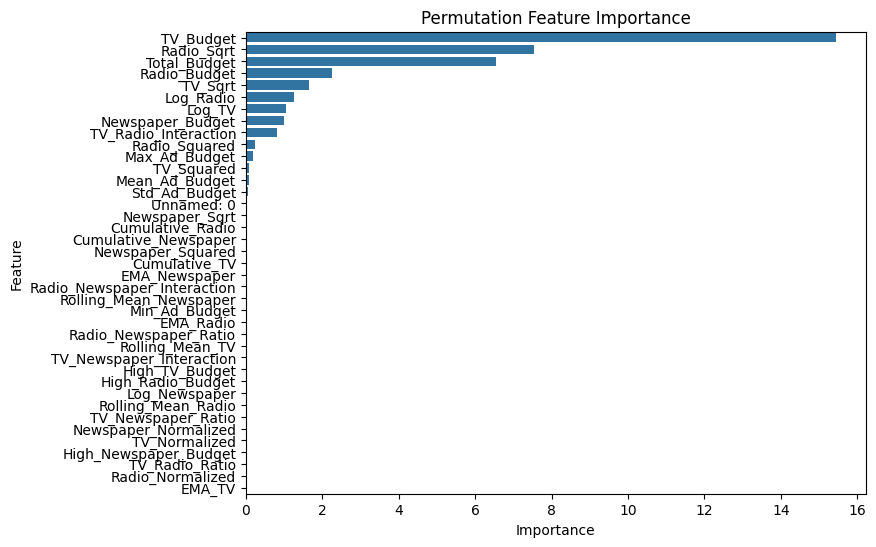

In [120]:
# Plot feature importance
plt.figure(figsize=(8, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title("Permutation Feature Importance")
plt.show()

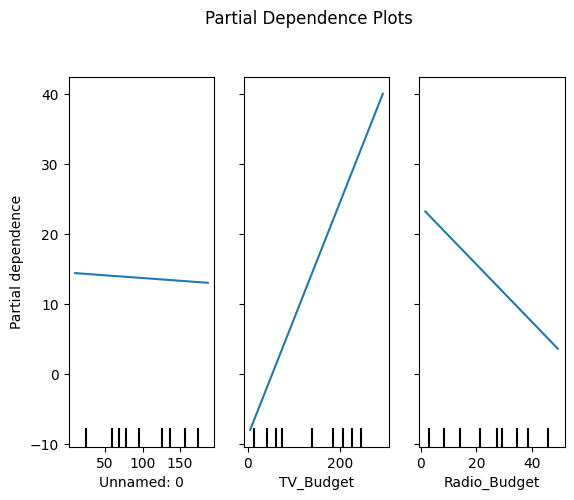

In [121]:
# Partial Dependence Plots (PDP)
PartialDependenceDisplay.from_estimator(best_model, X_test, features=[0, 1, 2], feature_names=X.columns)
plt.suptitle("Partial Dependence Plots", y=1.02)
plt.show()


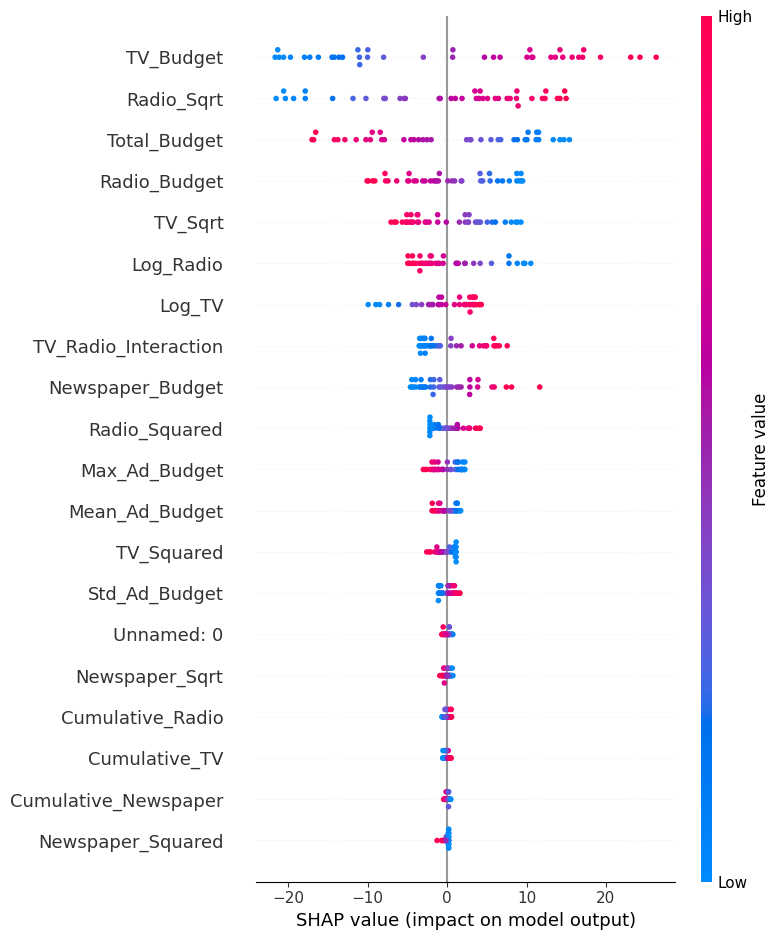

In [122]:
# Initialize SHAP JavaScript visualization
shap.initjs()

# Create SHAP explainer for the best model
explainer = shap.Explainer(best_model, X_test)
shap_values = explainer(X_test)

# Global SHAP Summary Plot
shap.summary_plot(shap_values, X_test)

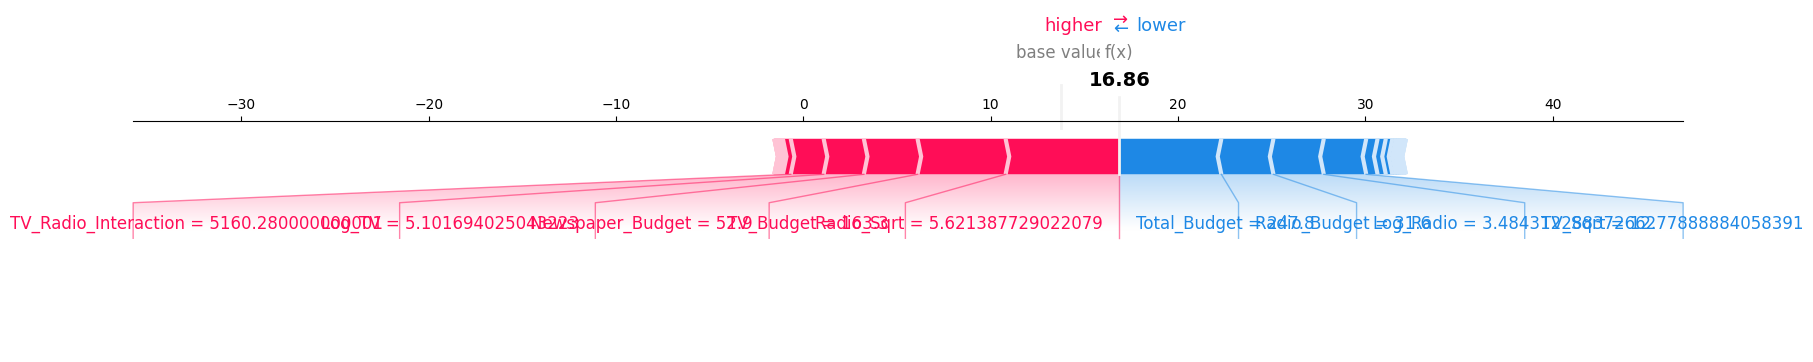

In [123]:
# Local SHAP Explanation for a single prediction
# Use matplotlib=True to render the force plot as a static image in Colab
shap.force_plot(explainer.expected_value, shap_values.values[0, :], X_test.iloc[0, :], matplotlib=True)

# Marketing Channel Optimization

In [129]:
# Simulate budget adjustments with all features
def simulate_budget_adjustment(tv, radio, newspaper, data):
    # Create a new DataFrame for the input row
    new_data = pd.DataFrame({
        'TV Ad Budget ($)': [tv],
        'Radio Ad Budget ($)': [radio],
        'Newspaper Ad Budget ($)': [newspaper]
    })

    # Recalculate all derived features based on the new budgets
    new_data['Newspaper_Budget'] = newspaper
    new_data['Radio_Budget'] = radio
    new_data['TV_Budget'] = tv
    new_data['Total_Budget'] = new_data['TV Ad Budget ($)'] + new_data['Radio Ad Budget ($)'] + new_data['Newspaper Ad Budget ($)']
    new_data['TV_Radio_Interaction'] = new_data['TV Ad Budget ($)'] * new_data['Radio Ad Budget ($)']
    new_data['TV_Newspaper_Interaction'] = new_data['TV Ad Budget ($)'] * new_data['Newspaper Ad Budget ($)']
    new_data['Radio_Newspaper_Interaction'] = new_data['Radio Ad Budget ($)'] * new_data['Newspaper Ad Budget ($)']
    new_data['TV_Radio_Ratio'] = new_data['TV Ad Budget ($)'] / (new_data['Radio Ad Budget ($)'] + 1e-5)
    new_data['TV_Newspaper_Ratio'] = new_data['TV Ad Budget ($)'] / (new_data['Newspaper Ad Budget ($)'] + 1e-5)
    new_data['Radio_Newspaper_Ratio'] = new_data['Radio Ad Budget ($)'] / (new_data['Newspaper Ad Budget ($)'] + 1e-5)
    new_data['Log_TV'] = np.log1p(new_data['TV Ad Budget ($)'])
    new_data['Log_Radio'] = np.log1p(new_data['Radio Ad Budget ($)'])
    new_data['Log_Newspaper'] = np.log1p(new_data['Newspaper Ad Budget ($)'])
    new_data['TV_Squared'] = new_data['TV Ad Budget ($)'] ** 2
    new_data['Radio_Squared'] = new_data['Radio Ad Budget ($)'] ** 2
    new_data['Newspaper_Squared'] = new_data['Newspaper Ad Budget ($)'] ** 2
    new_data['TV_Sqrt'] = np.sqrt(new_data['TV Ad Budget ($)'])
    new_data['Radio_Sqrt'] = np.sqrt(new_data['Radio Ad Budget ($)'])
    new_data['Newspaper_Sqrt'] = np.sqrt(new_data['Newspaper Ad Budget ($)'])
    new_data['Mean_Ad_Budget'] = new_data[['TV Ad Budget ($)', 'Radio Ad Budget ($)', 'Newspaper Ad Budget ($)']].mean(axis=1)
    new_data['Std_Ad_Budget'] = new_data[['TV Ad Budget ($)', 'Radio Ad Budget ($)', 'Newspaper Ad Budget ($)']].std(axis=1)
    new_data['Max_Ad_Budget'] = new_data[['TV Ad Budget ($)', 'Radio Ad Budget ($)', 'Newspaper Ad Budget ($)']].max(axis=1)
    new_data['Min_Ad_Budget'] = new_data[['TV Ad Budget ($)', 'Radio Ad Budget ($)', 'Newspaper Ad Budget ($)']].min(axis=1)
    new_data['TV_Normalized'] = (new_data['TV Ad Budget ($)'] - data['TV_Budget'].mean()) / data['TV_Budget'].std()
    new_data['Radio_Normalized'] = (new_data['Radio Ad Budget ($)'] - data['Radio_Budget'].mean()) / data['Radio_Budget'].std()
    new_data['Newspaper_Normalized'] = (new_data['Newspaper Ad Budget ($)'] - data['Newspaper_Budget'].mean()) / data['Newspaper_Budget'].std()
    new_data['Cumulative_TV'] = new_data['TV Ad Budget ($)']  # For a single row, cumulative is the value itself
    new_data['Cumulative_Radio'] = new_data['Radio Ad Budget ($)']
    new_data['Cumulative_Newspaper'] = new_data['Newspaper Ad Budget ($)']
    new_data['Rolling_Mean_TV'] = new_data['TV Ad Budget ($)']  # For a single row, rolling mean is the value itself
    new_data['Rolling_Mean_Radio'] = new_data['Radio Ad Budget ($)']
    new_data['Rolling_Mean_Newspaper'] = new_data['Newspaper Ad Budget ($)']
    new_data['EMA_TV'] = new_data['TV Ad Budget ($)']  # For a single row, EMA is the value itself
    new_data['EMA_Radio'] = new_data['Radio Ad Budget ($)']
    new_data['EMA_Newspaper'] = new_data['Newspaper Ad Budget ($)']
    new_data['High_TV_Budget'] = (new_data['TV Ad Budget ($)'] > data['TV_Budget'].mean()).astype(int)
    new_data['High_Radio_Budget'] = (new_data['Radio Ad Budget ($)'] > data['Radio_Budget'].mean()).astype(int)
    new_data['High_Newspaper_Budget'] = (new_data['Newspaper Ad Budget ($)'] > data['Newspaper_Budget'].mean()).astype(int)

    # Predict sales using the best model
    predicted_sales = best_model.predict(new_data)
    return predicted_sales[0]

In [130]:
# Example: Simulate a new budget allocation
tv_budget = 200
radio_budget = 50
newspaper_budget = 30
predicted_sales = simulate_budget_adjustment(tv_budget, radio_budget, newspaper_budget, df)
print(f"\nPredicted Sales for TV: ${tv_budget}, Radio: ${radio_budget}, Newspaper: ${newspaper_budget} -> ${predicted_sales:.2f}")

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Newspaper Ad Budget ($)
- Radio Ad Budget ($)
- TV Ad Budget ($)
Feature names seen at fit time, yet now missing:
- Total_Budget
- Unnamed: 0
